In [1]:
# use dream_proj conda environment
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import glob

# auto reload source files
%load_ext autoreload
%autoreload 2
# add source directory to path
source_path = os.path.abspath(os.path.join('..'))
if source_path not in sys.path:
    sys.path.append(os.path.join(source_path, 'source'))
# read source files
#import read_data
import scanpy as sc


In [3]:
# write expr to csv 
# expr_df = pd.read_parquet('/cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_expression.parquet')
# expr_df.to_csv('/cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_expression.tsv', sep='\t')

In [2]:
# read in gene converter
ensembl_to_gene_symbol_df = pd.read_csv('/cellar/users/zkoch/dream/utilities/ensembl_to_geneSymbol.tsv', delimiter='\t', header=None)
ensembl_to_gene_symbol_df.columns = ['ensembl', 'gene_symbol']

In [3]:
# read in expression data and process 
adata = sc.read_csv('/cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_expression.tsv', delimiter='\t').T
# remove anything after . in ensembl id
adata.var.index = adata.var.index.str.split('.').str[0]
# replace ensembl ids with gene symbols
adata.var.index = adata.var.index.map(dict(zip(ensembl_to_gene_symbol_df.ensembl, ensembl_to_gene_symbol_df.gene_symbol)))
# remove resulting nans 
rows_with_nan = adata.var_names.isna()
# Invert the boolean index to get the rows without NaN in ann.var_names
rows_without_nan = ~rows_with_nan
# Use boolean indexing to filter the AnnData object
adata = adata[:, rows_without_nan]
# drop duplicate gene symbols
adata = adata[:,~adata.var.index.duplicated()]

In [7]:
# read in dream-regulated genes 
#dream_reg_genes = pd.read_csv('/cellar/users/zkoch/dream/data/bujarrabal_dueso/tableS12_dream_promoter_binding.csv', delimiter='\t', header=None)

dream_regulated_genes = pd.read_csv(
            "/cellar/users/zkoch/dream/data/bujarrabal_dueso/tableS12_dream_promoter_binding.csv", index_col=0
            )
# replace spaces with underscores and make lowercase
dream_regulated_genes.columns = [
    x.lower().replace(" ", "_") for x in dream_regulated_genes.columns
    ]
dream_regulated_genes_l = dream_regulated_genes['gene_name'].to_list()

In [9]:
# read in cell cylce genes
cell_cycle_genes = [x.strip() for x in open('/cellar/users/zkoch/dream/utilities/regev_lab_cell_cycle_genes.txt')]
print("original number of cell cycle genes: {}".format(len(cell_cycle_genes)))
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
# remove dream regulated genes from cell cycle genes
cell_cycle_genes = [x for x in cell_cycle_genes if x not in dream_regulated_genes_l]
print("number of cell cycle genes after removing dream regulated genes: {}".format(len(cell_cycle_genes)))
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print("number of cell cycle genes in data: {}".format(len(cell_cycle_genes)))

# also remove dream regulated genes from s and g2m genes
s_genes = [x for x in s_genes if x not in dream_regulated_genes_l]
g2m_genes = [x for x in g2m_genes if x not in dream_regulated_genes_l]
# remove genes not in data
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]

original number of cell cycle genes: 97
number of cell cycle genes after removing dream regulated genes: 54
number of cell cycle genes in data: 51


In [10]:
# do recomended filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# and scaling
sc.pp.log1p(adata)
sc.pp.scale(adata)

/cellar/users/zkoch/miniconda3/envs/cellXgene2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [11]:
# do cell cycle gene scoring 
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

## Not removing DREAM genes

/cellar/users/zkoch/miniconda3/envs/cellXgene2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


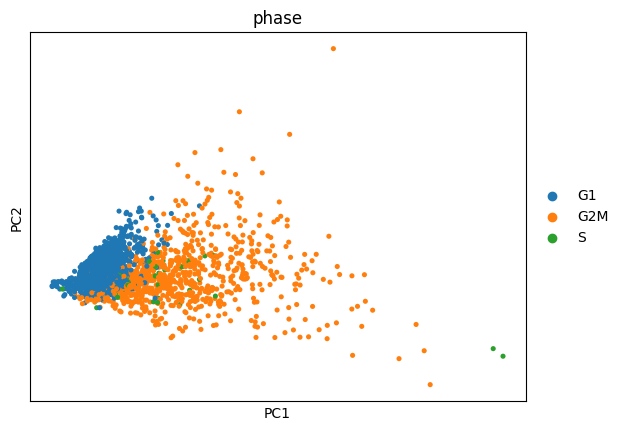

In [6]:
# calculating pca on cell cycle genes before scaling
# without log scaling 
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

/cellar/users/zkoch/miniconda3/envs/cellXgene2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


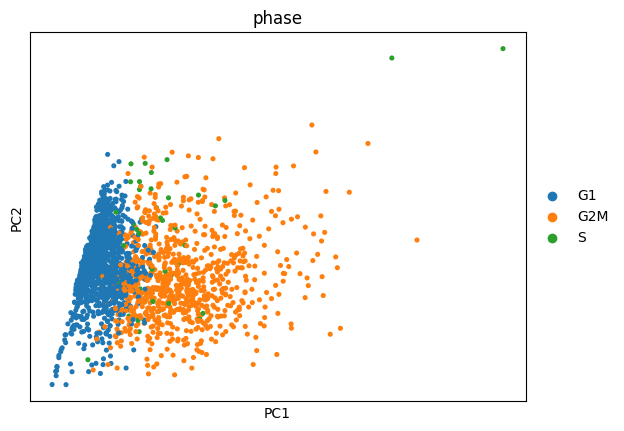

In [9]:
# calculating pca on cell cycle genes before scaling
# with log scaling 
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

/cellar/users/zkoch/miniconda3/envs/cellXgene2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


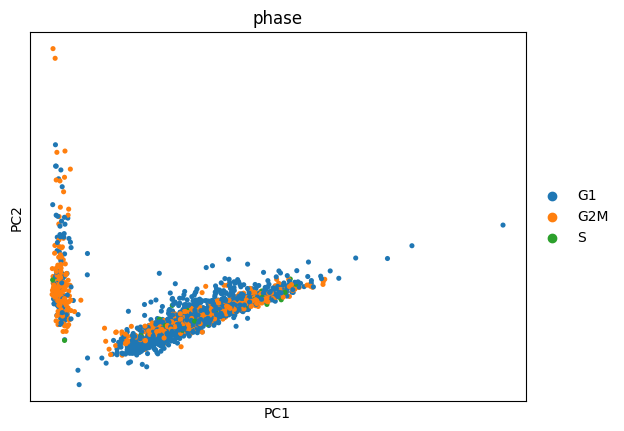

In [7]:
# calculating pca on aLL genes before scaling
# without log scaling
adata_all_genes = adata
sc.tl.pca(adata_all_genes)
sc.pl.pca_scatter(adata_all_genes, color='phase')

/cellar/users/zkoch/miniconda3/envs/cellXgene2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


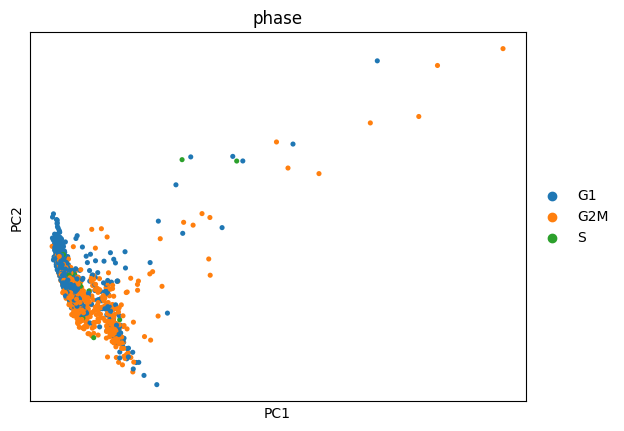

In [10]:
# calculating pca on aLL genes before scaling
# without scaling
adata_all_genes = adata
sc.tl.pca(adata_all_genes)
sc.pl.pca_scatter(adata_all_genes, color='phase')

In [11]:
# regressing out cell cycle effects 
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
sc.pp.scale(adata)

/cellar/users/zkoch/miniconda3/envs/cellXgene2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


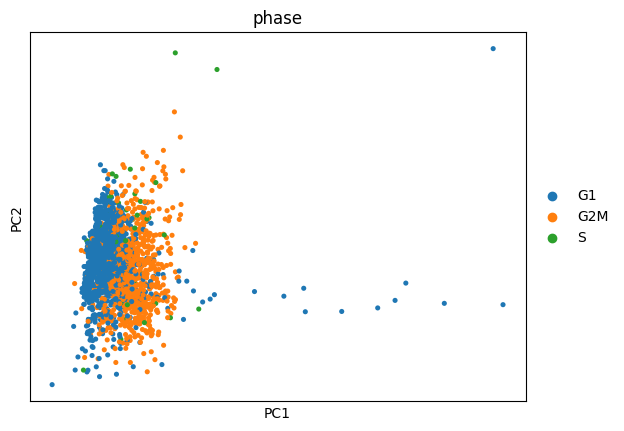

In [12]:
# PCA on cell cyhcle genes after regressing out cell cycle effects
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

/cellar/users/zkoch/miniconda3/envs/cellXgene2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


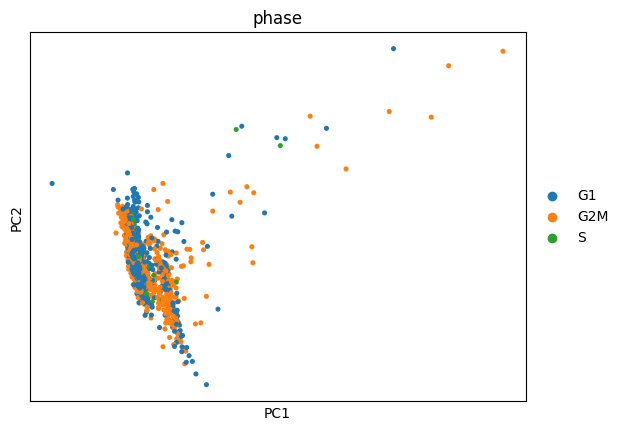

In [13]:
# PCA on all  genes after regressing out cell cycle effects
adata_all_genes = adata
sc.tl.pca(adata_all_genes)
sc.pl.pca_scatter(adata_all_genes, color='phase')

In [15]:
# convert the adata object to a pandas dataframe
adata_df = adata.to_df()

In [21]:
# add  adata.obs[['S_score', 'G2M_score', 'phase']] to adata_df
adata_df = pd.merge (adata_df, adata.obs[['S_score', 'G2M_score',]], left_index=True, right_index=True)

In [24]:
adata.obs[['S_score', 'G2M_score']].to_parquet('/cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_cell_cycle_scores.parquet')

## Removing DREAM genes

In [14]:
# convert the adata object to a pandas dataframe
adata_df = adata.to_df()
# add  adata.obs[['S_score', 'G2M_score', 'phase']] to adata_df
adata_df = pd.merge (adata_df, adata.obs[['S_score', 'G2M_score',]], left_index=True, right_index=True)
adata.obs[['S_score', 'G2M_score']].to_parquet('/cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_cell_cycle_scores_no_DREAM_reg_genes.parquet')

# What proportion of DREAM regulated genes are called cell cycle by this list?

In [71]:
dream_regulated_genes = pd.read_csv("/cellar/users/zkoch/dream/data/bujarrabal_dueso/tableS12_dream_promoter_binding.csv")

In [74]:
len(set(dream_regulated_genes['Gene name'].to_list()).intersection(set(cell_cycle_genes)))

43

In [85]:
len(set(dream_regulated_genes.query("`INDY DNA repair UP` == 1")['Gene name'].to_list()).intersection(set(cell_cycle_genes)))


6

In [86]:
dream_regulated_genes.query("`INDY DNA repair UP` == 1").shape

(46, 5)

In [70]:
cell_cycle_genes

['MCM5',
 'PCNA',
 'TYMS',
 'FEN1',
 'MCM2',
 'MCM4',
 'RRM1',
 'UNG',
 'GINS2',
 'MCM6',
 'CDCA7',
 'DTL',
 'PRIM1',
 'UHRF1',
 'HELLS',
 'RFC2',
 'RPA2',
 'NASP',
 'RAD51AP1',
 'GMNN',
 'WDR76',
 'SLBP',
 'CCNE2',
 'UBR7',
 'POLD3',
 'MSH2',
 'ATAD2',
 'RAD51',
 'RRM2',
 'CDC45',
 'CDC6',
 'EXO1',
 'TIPIN',
 'DSCC1',
 'BLM',
 'CASP8AP2',
 'USP1',
 'CLSPN',
 'POLA1',
 'CHAF1B',
 'BRIP1',
 'E2F8',
 'HMGB2',
 'CDK1',
 'NUSAP1',
 'UBE2C',
 'BIRC5',
 'TPX2',
 'TOP2A',
 'NDC80',
 'CKS2',
 'NUF2',
 'CKS1B',
 'MKI67',
 'TMPO',
 'CENPF',
 'TACC3',
 'SMC4',
 'CCNB2',
 'CKAP2L',
 'CKAP2',
 'AURKB',
 'BUB1',
 'KIF11',
 'ANP32E',
 'TUBB4B',
 'GTSE1',
 'KIF20B',
 'HJURP',
 'CDCA3',
 'CDC20',
 'TTK',
 'CDC25C',
 'KIF2C',
 'RANGAP1',
 'NCAPD2',
 'DLGAP5',
 'CDCA2',
 'CDCA8',
 'ECT2',
 'KIF23',
 'HMMR',
 'AURKA',
 'PSRC1',
 'ANLN',
 'LBR',
 'CKAP5',
 'CENPE',
 'CTCF',
 'NEK2',
 'G2E3',
 'GAS2L3',
 'CBX5',
 'CENPA']